<a href="https://colab.research.google.com/github/DGkurnia/cnkproject/blob/main/BMLP_Derfansyah_Guswiranata_Kurnia_clus_ii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perkenalan Diri
## Nama (iddicoding): Derfansyah Guswiranata Kurnia (dgkurnia)
## email dicoding: weerakurnia@gmail

# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

In [1]:
#Pengunduhan dataset ke google colab
from google.colab import files
#ke proses 'upload'

In [2]:
#Tahap penguploadan
uploaded = files.upload()

Saving vgchartz-2024.csv to vgchartz-2024.csv


# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [3]:
#Peprustakaan dasar
import numpy as np
import pandas as pd
#Grafik
import matplotlib.pyplot as plt
import seaborn as sns
#perpustakaan untuk interpolasi
from scipy.interpolate import interp1d

In [4]:
#Bagian K-means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
#ke pelabelan

In [5]:
#Perpustakaan untuk inisiasi 'pelabelan' dan 'identifikasi jarak'
from sklearn.preprocessing import LabelEncoder as le
from sklearn.decomposition import PCA
from scipy.spatial import distance
#Inisiasi scaler
from sklearn.preprocessing import StandardScaler #untuk PCA
from sklearn.preprocessing import RobustScaler #hierarki

In [6]:
#Dasar Agglomerasi
from sklearn.cluster import AgglomerativeClustering as agcl #pengingat
import scipy.cluster.hierarchy as sch #hierarki
from scipy.cluster.hierarchy import dendrogram, linkage

In [10]:
# instalasi pool
import warnings #peringatan
import multiprocessing
from multiprocessing import Pool
import os #untuk os
import time
import datetime

In [8]:
#instalasi dill
! pip install dill
import dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.6 MB/s eta 0:00:00


In [7]:
#optsional untuk hierarki 'kneed'
!pip install kneed
from kneed import KneeLocator

In [11]:
#Silhouette visualizer
!pip install yellowbrick
from yellowbrick.cluster import SilhouetteVisualizer

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [12]:
#Persiapan dataset melalui Pengunduhan dataset
sdf = pd.read_csv('/content/vgchartz-2024.csv')
sdfc = sdf.copy()

In [13]:
#Bagian Penyeleksian kolom penjualan
kolpen = ['total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales'] #indikator bagi penjualan
numerik = sdfc[kolpen].copy() #kolom numerik penjualan
#lihat contoh
cnth = numerik.head(7) #7 sampel
print("contoh data penjualan:")
print(cnth)

contoh data penjualan:
   total_sales  na_sales  jp_sales  pal_sales  other_sales
0        20.32      6.37      0.99       9.85         3.12
1        19.39      6.06      0.60       9.71         3.02
2        16.15      8.41      0.47       5.49         1.78
3        15.86      9.06      0.06       5.33         1.42
4        15.09      6.18      0.41       6.05         2.44
5        14.82      9.07      0.13       4.29         1.33
6        14.74      9.76      0.11       3.73         1.14


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [14]:
#cek info data
catatan = sdfc.info()
print("informais data:")
print(catatan)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   img           64016 non-null  object 
 1   title         64016 non-null  object 
 2   console       64016 non-null  object 
 3   genre         64016 non-null  object 
 4   publisher     64016 non-null  object 
 5   developer     63999 non-null  object 
 6   critic_score  6678 non-null   float64
 7   total_sales   18922 non-null  float64
 8   na_sales      12637 non-null  float64
 9   jp_sales      6726 non-null   float64
 10  pal_sales     12824 non-null  float64
 11  other_sales   15128 non-null  float64
 12  release_date  56965 non-null  object 
 13  last_update   17879 non-null  object 
dtypes: float64(6), object(8)
memory usage: 6.8+ MB
informais data:
None


### Hal pengingat
1. Nilai kritik berasal dari nilai skala 10
2. Satuan nilai penjualan adalah juta sehingga nilai 20.05 menyatakan 20 juta lima puluh ribu (2,05 *10^7)

In [15]:
#Inisiasi bagian awal (cek jumlah penjualan)
top15jdl = sdfc.groupby('title')['total_sales'].sum().sort_values(ascending=False).head(15).copy() #Lihat urutan dahulu
#lihat hasil
top15jdl #lihat judul dl

,total_sales
title,
Grand Theft Auto V,64.29
Call of Duty: Black Ops,30.99
Call of Duty: Modern Warfare 3,30.71
Call of Duty: Black Ops II,29.59
Call of Duty: Ghosts,28.80
Call of Duty: Black Ops 3,26.72
Call of Duty: Modern Warfare 2,25.02
Minecraft,24.01
Grand Theft Auto IV,22.53


# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang perlu dilakukan, namun **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

In [16]:
#Tahap 1 (cek data kosong)
totkosong = sdf.isnull().sum() #totalnya saja
print("total data kosong:")
print(totkosong)

total data kosong:
img                 0
title               0
console             0
genre               0
publisher           0
developer          17
critic_score    57338
total_sales     45094
na_sales        51379
jp_sales        57290
pal_sales       51192
other_sales     48888
release_date     7051
last_update     46137
dtype: int64


In [17]:
#Pengisian kolom pengembang
kolpen = sdfc['developer'].copy() #salinan dari kolom pengembang/'developer'
kolpbt = sdfc['publisher'].copy() #salinan dari penerbit/'publisher'
pengkosong = np.where(kolpen.isnull(),True,False) #cek kolom pengembang kosong
#pengisian pengembang dari penerbit
kolpen = kolpen.fillna(kolpbt)
#cek proses pengisian
smpkpen = sdfc.head(7)
smpkpen

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,NaN
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17,NaN
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14
5,/games/boxart/full_call-of-duty-modern-warfare...,Call of Duty: Modern Warfare 3,X360,Shooter,Activision,Infinity Ward,8.7,14.82,9.07,0.13,4.29,1.33,2011-11-08,NaN
6,/games/boxart/full_call-of-duty-black-ops_5Ame...,Call of Duty: Black Ops,X360,Shooter,Activision,Treyarch,8.8,14.74,9.76,0.11,3.73,1.14,2010-11-09,NaN


In [19]:
#Pengisian kolom penjualan dengan nilai interpolasi
kolpen = numerik.interpolate(method='nearest',limit_direction='both',limit_area='inside')
kolpen = numerik.interpolate(method='linear',limit_direction='both',limit_area='outside')
#cek hasil penyatuan
#cek proses pengisian
smpkpen = kolpen.head(7)
#lihat hasil
smpkpen

,total_sales,na_sales,jp_sales,pal_sales,other_sales
0,20.32,6.37,0.99,9.85,3.12
1,19.39,6.06,0.60,9.71,3.02
2,16.15,8.41,0.47,5.49,1.78
3,15.86,9.06,0.06,5.33,1.42
4,15.09,6.18,0.41,6.05,2.44
5,14.82,9.07,0.13,4.29,1.33
6,14.74,9.76,0.11,3.73,1.14


In [20]:
#lihat hasil beda untuk verifikasi
bdjual = sdfc[np.where(abs(sdfc['total_sales'] - sdfc[['na_sales', 'jp_sales', 'pal_sales', 'other_sales']].sum(axis=1)) > 0.1,True, False)].shape[0]
print("jumlah perbedaan :")
print(bdjual)

jumlah perbedaan :
0


## Pengisian tanggal yang kosong

In [21]:
#Bagian 1 (pembaruan jika tidak memiliki tanggal publikasi)
koltang = sdfc['release_date'].isnull() & sdfc['last_update'].notnull() #Kondisi 1
sdfc.loc[np.where(koltang, True, False), 'release_date'] = sdfc.loc[np.where(koltang, True, False),'release_date'].fillna(sdfc['last_update'])
#cek pengisian pertama
inspk1 = sdfc[np.where(koltang, True, False)].head(7)
inspk1
#ke tahap 2

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
6347,/games/boxart/full_dangan-ronpa_0JapanFront.jpg,Danganronpa: Trigger Happy Havoc,PSP,Adventure,Unknown,Spike,NaN,0.24,NaN,0.24,NaN,NaN,2018-01-11,2018-01-11
14436,/games/boxart/full_8639439JapanFrontccc.jpg,PriPara All Idol Perfect Stage!,NS,Misc,Unknown,Takara Tomy ARTS,NaN,0.03,NaN,0.03,NaN,NaN,2018-04-04,2018-04-04
15449,/games/boxart/full_9121088AmericaFrontccc.jpg,Zumba Fitness: World Party,X360,Misc,Unknown,Zoe Mode,NaN,0.02,NaN,NaN,0.02,0.0,2018-04-01,2018-04-01
19006,/games/boxart/full_8394432AmericaFrontccc.jpg,How to Survive 2,PC,Action,Unknown,EKO Software,NaN,NaN,NaN,NaN,NaN,NaN,2019-02-02,2019-02-02
19066,/games/boxart/full_6903656AmericaFrontccc.jpg,Geometry Dash,PC,Action,Unknown,RobTop Games,NaN,NaN,NaN,NaN,NaN,NaN,2019-02-03,2019-02-03
19069,/games/boxart/full_6115800AmericaFrontccc.jpg,Who's Your Daddy,PC,Action,Unknown,Evil Tortilla Games,NaN,NaN,NaN,NaN,NaN,NaN,2019-02-03,2019-02-03
19093,/games/boxart/full_4549936AmericaFrontccc.jpg,Super Hexagon,PC,Action,Unknown,Terry Cavanagh,NaN,NaN,NaN,NaN,NaN,NaN,2019-02-05,2019-02-05


In [22]:
#Kondisi 2 (tidak memiliki tanggal pembaruan)
koltang = sdfc['release_date'].notnull() & sdfc['last_update'].isnull()
sdfc.loc[np.where(koltang, True, False), 'last_update'] = sdfc.loc[np.where(koltang, True, False),'last_update'].fillna(sdfc['release_date'])
#cek bagian kedia
sdfc[np.where(koltang, True, False)].head(7)

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,2013-09-17
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,2002-10-28
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17,2013-09-17
5,/games/boxart/full_call-of-duty-modern-warfare...,Call of Duty: Modern Warfare 3,X360,Shooter,Activision,Infinity Ward,8.7,14.82,9.07,0.13,4.29,1.33,2011-11-08,2011-11-08
6,/games/boxart/full_call-of-duty-black-ops_5Ame...,Call of Duty: Black Ops,X360,Shooter,Activision,Treyarch,8.8,14.74,9.76,0.11,3.73,1.14,2010-11-09,2010-11-09
10,/games/boxart/full_809251AmericaFrontccc.jpg,Call of Duty: Modern Warfare 2,X360,Shooter,Activision,Infinity Ward,9.5,13.53,8.54,0.08,3.63,1.28,2009-11-10,2009-11-10
12,/games/boxart/full_call-of-duty-modern-warfare...,Call of Duty: Modern Warfare 3,PS3,Shooter,Activision,Infinity Ward,8.8,13.35,5.54,0.49,5.78,1.54,2011-11-08,2011-11-08


In [23]:
#Kondisi 3 (keduanya kosong)
koltang = sdfc['release_date'].isnull() & sdfc['last_update'].isnull()
rctgl = sdfc[koltang].describe().round(3) #lihat hasil
rctgl #cek kolom koson

,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales
count,25.000,87.000,17.000,36.000,47.000,56.000
mean,6.868,0.072,0.045,0.074,0.046,0.011
std,1.633,0.210,0.080,0.090,0.163,0.045
min,2.500,0.000,0.000,0.000,0.000,0.000
25%,6.000,0.000,0.000,0.018,0.000,0.000
50%,7.000,0.020,0.010,0.040,0.010,0.000
75%,8.000,0.060,0.020,0.103,0.025,0.000
max,9.000,1.840,0.250,0.420,1.100,0.330


In [24]:
#Pengisian tanggal
sdfc['release_date'] = sdfc['release_date'].fillna(datetime.datetime(1900, 1, 1)).copy()
sdfc['last_update'] = sdfc['last_update'].fillna(datetime.datetime(1900, 1, 1)).copy()

In [26]:
#isi nilai kritik
nilkrit = sdfc['critic_score'].copy()
nilkrit = nilkrit.interpolate(method='nearest',limit_direction='both',limit_area='inside') #tahap 1
nilkrit = nilkrit.interpolate(method='linear',limit_direction='both',limit_area='outside')
#lihat kolom
sdfc['critic_score'] = nilkrit
nilkrit.describe()

,critic_score
count,64016.000000
mean,7.046607
std,1.550054
min,1.000000
25%,6.200000
50%,7.300000
75%,8.100000
max,10.000000


In [27]:
#lihat contoh kolom jadi
koltgl = pd.concat([sdfc['release_date'],sdfc['last_update']], axis=1, sort=True, copy=True) #Keamanan
#lihat info
inftgl = koltgl.info()
inftgl

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   release_date  64016 non-null  object
 1   last_update   64016 non-null  object
dtypes: object(2)
memory usage: 1000.4+ KB


#### Persiapan kolom untuk penyatuan

In [28]:
#Tahap 1 (penyatuan penjualan dan kritik)
totnumkol = pd.concat([kolpen, nilkrit], axis=1, sort=True, copy=True) #Jangan pakai data asli
infototkolnum = totnumkol.info()
print("informasi data:")
infototkolnum

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   total_sales   64016 non-null  float64
 1   na_sales      57731 non-null  float64
 2   jp_sales      51826 non-null  float64
 3   pal_sales     57919 non-null  float64
 4   other_sales   60222 non-null  float64
 5   critic_score  64016 non-null  float64
dtypes: float64(6)
memory usage: 2.9 MB
informasi data:


Bagian 1 dari kolom jadi

In [29]:
#Tahap 2: Inspeksi untuk seleksi kolom (penyatuan hasil data)
sisa = sdfc.iloc[:,:5].copy()
sisa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   img        64016 non-null  object
 1   title      64016 non-null  object
 2   console    64016 non-null  object
 3   genre      64016 non-null  object
 4   publisher  64016 non-null  object
dtypes: object(5)
memory usage: 2.4+ MB


Bagian 2

In [30]:
#Persiapan kolom bersih untuk pembuatan cluster
sdfcbsh = pd.concat([sisa,totnumkol, koltgl], axis=1, sort=True, copy=True) #Ak harap benar
infodfbsh = sdfcbsh.info()
#lihat info
infodfbsh

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   img           64016 non-null  object 
 1   title         64016 non-null  object 
 2   console       64016 non-null  object 
 3   genre         64016 non-null  object 
 4   publisher     64016 non-null  object 
 5   total_sales   64016 non-null  float64
 6   na_sales      57731 non-null  float64
 7   jp_sales      51826 non-null  float64
 8   pal_sales     57919 non-null  float64
 9   other_sales   60222 non-null  float64
 10  critic_score  64016 non-null  float64
 11  release_date  64016 non-null  object 
 12  last_update   64016 non-null  object 
dtypes: float64(6), object(7)
memory usage: 6.3+ MB


In [34]:
#Pembersihan tahp 2 untuk penjualan
klpen2 = sdfcbsh.iloc[:,6:10].copy() #pembersihan ulang
klpen2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   na_sales     57731 non-null  float64
 1   jp_sales     51826 non-null  float64
 2   pal_sales    57919 non-null  float64
 3   other_sales  60222 non-null  float64
dtypes: float64(4)
memory usage: 2.0 MB


In [38]:
#Pengisian melalui interpolasi
klpen2 = klpen2.interpolate(method='nearest',limit_direction='both',limit_area='inside') #tahap 1
klpen2 = klpen2.interpolate(method='linear',limit_direction='both',limit_area='outside') #tahap 2
klpen2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   na_sales     64016 non-null  float64
 1   jp_sales     64016 non-null  float64
 2   pal_sales    64016 non-null  float64
 3   other_sales  64016 non-null  float64
dtypes: float64(4)
memory usage: 2.0 MB


In [43]:
#cek kolom setelah pembersihan
dfbshp1 = sdfcbsh.iloc[:, :6].copy()
dfbshp2 = sdfcbsh.iloc[:, 10:].copy()
dfbshmk2 = pd.concat([dfbshp1, klpen2, dfbshp2], axis=1, sort=True, copy=True) #Jangan salah lagi
dfbshmk2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   img           64016 non-null  object 
 1   title         64016 non-null  object 
 2   console       64016 non-null  object 
 3   genre         64016 non-null  object 
 4   publisher     64016 non-null  object 
 5   total_sales   64016 non-null  float64
 6   na_sales      64016 non-null  float64
 7   jp_sales      64016 non-null  float64
 8   pal_sales     64016 non-null  float64
 9   other_sales   64016 non-null  float64
 10  critic_score  64016 non-null  float64
 11  release_date  64016 non-null  object 
 12  last_update   64016 non-null  object 
dtypes: float64(6), object(7)
memory usage: 6.3+ MB


Ini adalah hasil yang lebih bersih

#### Proses Pelabelan

In [44]:
#Persiapan untuk pengisian melalui deklarasi jenis konsol
jkonsol = sdfcbsh['console'].unique().copy() #salinan saja
print("jenis konsol:")
print(jkonsol)

jenis konsol:
['PS3' 'PS4' 'PS2' 'X360' 'XOne' 'PC' 'PSP' 'Wii' 'PS' 'DS' '2600' 'GBA'
 'NES' 'XB' 'PSN' 'GEN' 'PSV' 'DC' 'N64' 'SAT' 'SNES' 'GBC' 'GC' 'NS'
 '3DS' 'GB' 'WiiU' 'WS' 'VC' 'NG' 'WW' 'SCD' 'PCE' 'XBL' '3DO' 'GG' 'OSX'
 'Mob' 'PCFX' 'Series' 'All' 'iOS' '5200' 'And' 'DSiW' 'Lynx' 'Linux' 'MS'
 'ZXS' 'ACPC' 'Amig' '7800' 'DSi' 'AJ' 'WinP' 'iQue' 'GIZ' 'VB' 'Ouya'
 'NGage' 'AST' 'MSD' 'S32X' 'XS' 'PS5' 'Int' 'CV' 'Arc' 'C64' 'FDS' 'MSX'
 'OR' 'C128' 'CDi' 'CD32' 'BRW' 'FMT' 'ApII' 'Aco' 'BBCM' 'TG16']


In [45]:
#Bagian jenis game (deklarasi jenis game)
jaksi = sdfcbsh['genre'].unique().copy() #salinan saja
print("jenis aksi:")
print(jaksi)

jenis aksi:
['Action' 'Shooter' 'Action-Adventure' 'Sports' 'Role-Playing'
 'Simulation' 'Racing' 'Music' 'Misc' 'Fighting' 'Platform' 'Adventure'
 'Strategy' 'Puzzle' 'MMO' 'Sandbox' 'Party' 'Education' 'Board Game'
 'Visual Novel']


In [46]:
#Inisiasi pelabelan
le_k = le()  # Untuk konsol
le_j = le()  # Untuk jenis game

In [47]:
#Pelabelan
kolkon = sdfcbsh['console'].copy() #aplikasi untuk konsol
koljen = sdfcbsh['genre'].copy() #aplikasi untuk genre
#eksekusi pelabelan
matkon = le_k.fit_transform(kolkon)  # Konsol
matjen = le_j.fit_transform(koljen)    # Jenis game

In [49]:
#persiapan df
dfkon = pd.DataFrame(data=matkon, columns=['kemungkinan generasi'])  # DF untuk konsol
dfjen = pd.DataFrame(data=matjen, columns=['kemungkinan menyenangkan'])  # DF untuk jenis
#ke hasil untuk pemeriksaan

In [50]:
#lihat hasil
infsamp1 = dfkon.info()
infsamp2 = dfjen.info()
print("Informasi sampel konsol:")
print(infsamp1)
print("Informasi sampel jenis game:")
print(infsamp2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   kemungkinan generasi  64016 non-null  int64
dtypes: int64(1)
memory usage: 500.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 1 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   kemungkinan menyenangkan  64016 non-null  int64
dtypes: int64(1)
memory usage: 500.2 KB
Informasi sampel konsol:
None
Informasi sampel jenis game:
None


In [51]:
#penyatuan kolom pelabelan
hslvek = pd.concat([dfkon, dfjen], axis=1, sort=True, copy=True)
hslvek.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   kemungkinan generasi      64016 non-null  int64
 1   kemungkinan menyenangkan  64016 non-null  int64
dtypes: int64(2)
memory usage: 1000.4 KB


# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

In [53]:
#Penyatuan dataset untuk penskalaan
sdfkomb = pd.concat([dfbshmk2, hslvek], axis=1, sort=True, copy=True)
sdfkomb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   img                       64016 non-null  object 
 1   title                     64016 non-null  object 
 2   console                   64016 non-null  object 
 3   genre                     64016 non-null  object 
 4   publisher                 64016 non-null  object 
 5   total_sales               64016 non-null  float64
 6   na_sales                  64016 non-null  float64
 7   jp_sales                  64016 non-null  float64
 8   pal_sales                 64016 non-null  float64
 9   other_sales               64016 non-null  float64
 10  critic_score              64016 non-null  float64
 11  release_date              64016 non-null  object 
 12  last_update               64016 non-null  object 
 13  kemungkinan generasi      64016 non-null  int64  
 14  kemung

In [59]:
#ambil kolom penting
lbl = sdfkomb.iloc[:, [13,14]].copy()
numkolii = sdfkomb.iloc[:, 5:11].copy()
#persiapan kolom analisis numerik
stdscal = StandardScaler() #PCA
rbsscal = RobustScaler() #hierarki

In [61]:
#Eksekusi penskalaan (dua kali)
stdnmk = stdscal.fit_transform(numkolii) #untuk PCA
rbnmk = rbsscal.fit_transform(stdnmk) #untuk hierarki

In [62]:
#Pengubahan ke df
dfstdnmk = pd.DataFrame(data=stdnmk, columns=numkolii.columns)
dfrbnmk = pd.DataFrame(data=rbnmk, columns=numkolii.columns)

In [63]:
#Lihat hasil (standar)
dfstdnmk.head(7)

,total_sales,na_sales,jp_sales,pal_sales,other_sales,critic_score
0,43.291200,25.764981,9.890744,52.679756,48.324018,1.518277
1,41.299748,24.499722,5.872512,51.928485,46.769901,1.711821
2,34.361784,34.091206,4.533102,29.283037,27.498858,1.647306
3,33.740793,36.744169,0.308807,28.424442,21.904039,1.647306
4,32.091956,24.989500,3.914912,32.288121,37.756026,0.679590
5,31.513792,36.784984,1.030028,22.843574,20.505334,1.066677
6,31.342484,39.601207,0.823965,19.838490,17.552513,1.131191


In [65]:
#lihat hasil (robust)
dfrbnmk.head(7)

,total_sales,na_sales,jp_sales,pal_sales,other_sales,critic_score
0,1016.0,637.0,99.0,52.857266,48.488431,1.105263
1,969.5,606.0,60.0,52.105995,46.934315,1.263158
2,807.5,841.0,47.0,29.460547,27.663272,1.210526
3,793.0,906.0,6.0,28.601952,22.068453,1.210526
4,754.5,618.0,41.0,32.465630,37.920440,0.421053
5,741.0,907.0,13.0,23.021083,20.669748,0.736842
6,737.0,976.0,11.0,20.016000,17.716927,0.789474


## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

In [66]:
#Bagian awal (siapkan bahanya)
sdfbhn = pd.concat([dfrbnmk, lbl], axis=1, sort=True, copy=True)
sdfbhn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   total_sales               64016 non-null  float64
 1   na_sales                  64016 non-null  float64
 2   jp_sales                  64016 non-null  float64
 3   pal_sales                 64016 non-null  float64
 4   other_sales               64016 non-null  float64
 5   critic_score              64016 non-null  float64
 6   kemungkinan generasi      64016 non-null  int64  
 7   kemungkinan menyenangkan  64016 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 3.9 MB


In [67]:
#pengambilan nilai untuk analisis fitur
nilkomp = sdfbhn.values.copy() #Nilai

In [70]:
#Deklarasi Batas
silmin = 0.55
optmin = 0.70
maxex = 43200 #12 jam dalam detik

In [91]:
#Fungsi (kluster divisif)
def dynamic_divisive_clustering(data, min_silhouette=silmin, optimal_silhouette=optmin, max_runtime=maxex):
    start_time = time.time()
    current_clusters = [data]  # Prepare initial cluster

    # Store results for each iteration
    results = {
        'silhouette_scores': [], #Nilai siluet
        'centers': [], #jumlah pusat
        'random_states': [] #nilai 'random state'
    }

    while current_clusters:
        elapsed_time = time.time() - start_time

        if elapsed_time > max_runtime:
            print("Penghetian karena batas waktu.")
            break

        # Prose 'pop' untuk penghapusan nilai terbesar
        cluster_to_split = current_clusters.pop(0)

        # Apply K-Means to split the cluster into two parts
        kmeans = KMeans(n_clusters=2)
        labels = kmeans.fit_predict(cluster_to_split)

        # Calculate silhouette score for the new clusters
        silhouette_avg = silhouette_score(cluster_to_split, labels)

        # Round silhouette score for clarity
        rounded_silhouette = round(silhouette_avg, 4)

        print(f"Nilai siluet untuk pembagian saat ini adalah : {rounded_silhouette}.")

        # Penyimpanan hasil
        results['silhouette_scores'].append(rounded_silhouette)
        results['centers'].append(kmeans.cluster_centers_)

        if rounded_silhouette >= min_silhouette:
            if rounded_silhouette >= optimal_silhouette:
                print("Optimal silhouette score achieved.")
                return results  # Return results when optimal score is reached

            elif rounded_silhouette < optimal_silhouette and rounded_silhouette >= min_silhouette:
                print("Minimum silhouette score achieved. Continuing...")
                # Continue clustering since minimum score is met

            else:
                print("Failed to achieve silhouette score.")

            # Store clusters for further inspection if conditions are met
            for label in np.unique(labels):
                current_clusters.append(cluster_to_split[labels == label])

    # Save intermediate results using dill for resumption purposes
    with open('intermediate_results.pkl', 'wb') as f:
        dill.dump(results, f)

    return results  # Return results at the end of the function
    #Persiapan paralel

In [92]:
# Fungsi Persiapan paralel
def run_parallel_clustering(data):
    with Pool(processes=os.cpu_count()) as pool:
        results = pool.map(dynamic_divisive_clustering, [data] * os.cpu_count())
    return results
  #ke persiapan data

In [93]:
#Persiapan data
datan = nilkomp.copy()

In [94]:
#Eksekusi untuk kondisi normal
hslnormal = dynamic_divisive_clustering(datan) #Kondisi normal
#cetak hasil
print(hslnormal)

Nilai siluet untuk pembagian saat ini adalah : 0.8598.
Optimal silhouette score achieved.
{'silhouette_scores': [0.8598], 'centers': [array([[ 3.26550115e+00,  3.69628985e+00,  2.80705640e+00,
         1.10295961e-01,  9.88039851e-02, -1.40193772e-01,
         4.79210505e+01,  9.24835061e+00],
       [ 1.52773736e+02,  1.64600493e+02,  1.82577065e+01,
         5.41577964e+00,  5.27767194e+00,  3.98857810e-01,
         5.61282367e+01,  1.02503083e+01]])], 'random_states': []}


## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

In [95]:
#Tahap awal fungsi dengan seleksi fitur
silminb = 0.55
optminb = 0.70
maxexb = 43200  # 12 jam dalam detik

In [96]:
#Fungsi
def dynamic_divisive_clustering_feature_selection(data, min_silhouette=silminb, optimal_silhouette=optminb, max_runtime=maxexb):
    start_time = time.time()
    current_data = data.copy()  # Persiapan data

    if isinstance(data, np.ndarray):
        current_data = pd.DataFrame(data)  # Pengubahan
    else:
        current_data = data.copy()

    # Store results for each iteration
    results = {
        'silhouette_scores': [],
        'centers': [],
        'random_states': []
    }

    feature_indices = list(range(current_data.shape[1]))  # Track feature indices

    while feature_indices:
        elapsed_time = time.time() - start_time

        if elapsed_time > max_runtime:
            print("Stopping due to maximum runtime.")
            break

        # Apply K-Means to split the data into two parts
        kmeans = KMeans(n_clusters=2)
        labels = kmeans.fit_predict(current_data)

        # Perhitungan dan pembulatan
        silhouette_avg = silhouette_score(current_data, labels)
        rounded_silhouette = round(silhouette_avg, 4)

        # Store relevant results
        results['silhouette_scores'].append(rounded_silhouette)
        results['centers'].append(kmeans.cluster_centers_)

        print(f"Silhouette Score: {rounded_silhouette}, Centers: {kmeans.cluster_centers_}")

        if rounded_silhouette >= min_silhouette:
            if rounded_silhouette >= optimal_silhouette:
                print("Optimal silhouette score achieved.")
                results['selected_features'] = current_data.columns[feature_indices].tolist()
                return results  # Return results when optimal score is reached

            elif rounded_silhouette < optimal_silhouette and rounded_silhouette >= min_silhouette:
                print("Minimum silhouette score achieved. Continuing...")
                # Continue clustering since minimum score is met
            else:
                print("Failed to achieve silhouette score.")

            # Evaluate feature importance by removing one feature at a time
            worst_feature_index = None
            worst_score = float('inf')

            for i in feature_indices:
                temp_features = current_data.drop(current_data.columns[i], axis=1)
                temp_labels = KMeans(n_clusters=2).fit_predict(temp_features)
                temp_score = silhouette_score(temp_features, temp_labels)

                if temp_score < worst_score:
                    worst_score = temp_score
                    worst_feature_index = i

            # Remove the worst feature if it improves or maintains the silhouette score
            if worst_feature_index is not None and worst_score >= rounded_silhouette:
                print(f"Removing feature: {current_data.columns[worst_feature_index]}")
                feature_indices.remove(worst_feature_index)

            results['selected_features'] = current_data.columns[feature_indices].tolist()

    # Save intermediate results using dill for resumption purposes
    with open('intermediate_sf_results.pkl', 'wb') as f:
        dill.dump(results, f)

    return results  # Return results at the end of the function
    #ke paralelisasi

In [97]:
#Paralelisasi
def run_parallel_clustering(data):
    with Pool(processes=os.cpu_count()) as pool:
        results = pool.map(dynamic_divisive_clustering_feature_selection, [data] * os.cpu_count())
    return results
#ke persiapan data

In [98]:
#eksekusi data
datan = nilkomp.copy()
#ke eksekusi

In [99]:
# Eksekusi untuk kondisi dengan seleksi fitur
hslsf = dynamic_divisive_clustering_feature_selection(datan)  # Kondisi dengan seleksi fitur
print(hslsf)

Silhouette Score: 0.8598, Centers: [[ 3.26550115e+00  3.69628985e+00  2.80705640e+00  1.10295961e-01
   9.88039851e-02 -1.40193772e-01  4.79210505e+01  9.24835061e+00]
 [ 1.52773736e+02  1.64600493e+02  1.82577065e+01  5.41577964e+00
   5.27767194e+00  3.98857810e-01  5.61282367e+01  1.02503083e+01]]
Optimal silhouette score achieved.
{'silhouette_scores': [0.8598], 'centers': [array([[ 3.26550115e+00,  3.69628985e+00,  2.80705640e+00,
         1.10295961e-01,  9.88039851e-02, -1.40193772e-01,
         4.79210505e+01,  9.24835061e+00],
       [ 1.52773736e+02,  1.64600493e+02,  1.82577065e+01,
         5.41577964e+00,  5.27767194e+00,  3.98857810e-01,
         5.61282367e+01,  1.02503083e+01]])], 'random_states': [], 'selected_features': [0, 1, 2, 3, 4, 5, 6, 7]}


## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

In [104]:
#Inisiasi PCA normal (pakai stdnmk)
pca = PCA(n_components=20)  # Adjust n_components as needed
hslpca = pca.fit_transform(stdnmk) #hasil
# Penjelasan rasio variansi
print(f'Nilai terinci untuk rasio variasi: {np.round(pca.explained_variance_ratio_,4)}')

Nilai terinci untuk rasio variasi: [0.6074 0.1661 0.1447 0.0524]


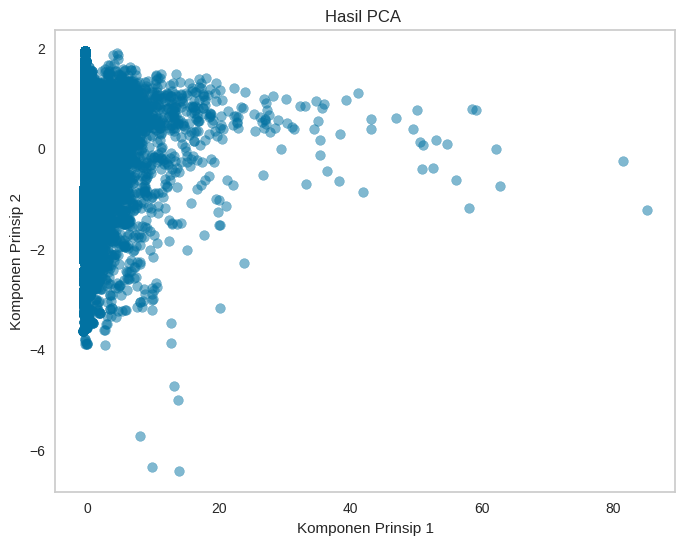

In [105]:
#Inspeksi dalam kondisi normal
plt.figure(figsize=(8,6))
plt.scatter(hslpca[:, 0], hslpca[:, 1], alpha=0.5)
plt.title('Hasil PCA ')
plt.xlabel('Komponen Prinsip 1')
plt.ylabel('Komponen Prinsip 2')
plt.grid()
plt.show()

Ada bagian menumpuk di bagian tengah

In [ ]:
#Dendogram normal
linked = linkage(hslpca, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [ ]:
#Aplikasi PCA untuk seleksi fitur (tetap sama)


## **e. Analisis dan Interpretasi Hasil Cluster**

Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

In [ ]:
#Type your code here

Tulis hasil interpretasinya di sini.
1. Cluster 1:
2. Cluster 2:
3. Cluster 3:

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.